In [63]:
from brian2 import *
import numpy as np

start_scope()

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    #print(global_clock)
    x = global_clock % 1
    if w >= 0:
       # print((x ** (1 - w)))
        return (x ** (1 - w)) + 0.004
    else:
        #print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w)) + 0.004
    
@implementation('numpy', discard_units=True)
@check_units(layer=1, result=1, sum=1, spikes_received=1)
def math1(layer, sum, spikes_received): 
    #print(spikes_received, sum)
    return (sum/spikes_received )+ layer

# Define network sizes
n_input = 4
n_hidden = 10
n_output = 3
n_total = n_input + n_hidden + n_output

# Full neuron group
neurons = NeuronGroup(n_total, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')

neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0

# Spike inputs (one per input neuron)
stim = SpikeGeneratorGroup(n_input, indices=range(n_input), times=[i*0.432 for i in range(n_input)]*ms)

# Input → Hidden connections
syn_input = Synapses(stim, neurons[0:n_input], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = math1(sum, spikes_received, layer) * ms
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = np.random.uniform(0.10, 0.95, size=4)
syn_input.layer = 1

# Hidden layer: input → hidden
syn_hidden = Synapses(neurons[0:n_input], neurons[n_input:n_input + n_hidden], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = math1(sum, spikes_received, layer) * ms
''')
syn_hidden.connect()
syn_hidden.w = np.random.uniform(0.10, 0.90, size=40)
syn_hidden.layer = 2

# Output layer: hidden → output
syn_output = Synapses(neurons[n_input:n_input + n_hidden], neurons[n_input + n_hidden:n_total], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = math1(sum, spikes_received, layer) * ms
   
''')
syn_output.connect()
syn_output.w = np.random.uniform(0.10, .90, size=30)
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.05*ms) * 1.2


                      
    global_clock += 0.001
''', dt=0.001*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.001*ms)
mon_sum = StateMonitor(neurons, 'sum', record=True)
sp_mon = StateMonitor(neurons, 'spikes_received', record=True)
sch_time = StateMonitor(neurons, 'scheduled_time', record=True)


spikemon = SpikeMonitor(neurons)

# Run
run(5*ms)

# # Plot voltages
# figure(figsize=(10, 6))
# for i in range(n_total):  # All neurons
#     plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
# xlabel('Time (ms)')
# ylabel('Membrane potential')
# legend()
# title('SNN Spike Propagation Across All Layers')
# show()

#plot(mon_sum.t/ms, mon_sum.sum[4])  # or any neuron index
print(mon_sum.sum[1])
print(sp_mon.spikes_received[1])
print(sch_time.scheduled_time[1])

# for i in spikemon.i:
#     times = spikemon.spike_trains()[i]
#     formatted = [f"{t/ms:.4f} ms" for t in times]  # Show 4 decimal places
#     print(f"Neuron {i} spike times: {formatted}")



WARNING    'i' is an internal variable of group 'synapses_183', but also exists in the run namespace with the value 5. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignor

[0.         0.         0.         0.         0.         0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966 0.63008966
 0.63008966 0.63008966]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
[1.00000000e+12 1.00000000e+12 1.00000000e+12 1.00000000e+12
 1.00000000e+12 1.63008966e+00 1.63008966e+00 1.63008966e+00
 1.63008966e+00 1.63008966e+00 1.63008966e+00 1.63008966e+00
 1.63008966e+00 1.63008966e+00 1.63008966e+00 1.63008966e+00
 1.63008966e+00 1.63008966e+00 1.63008966e

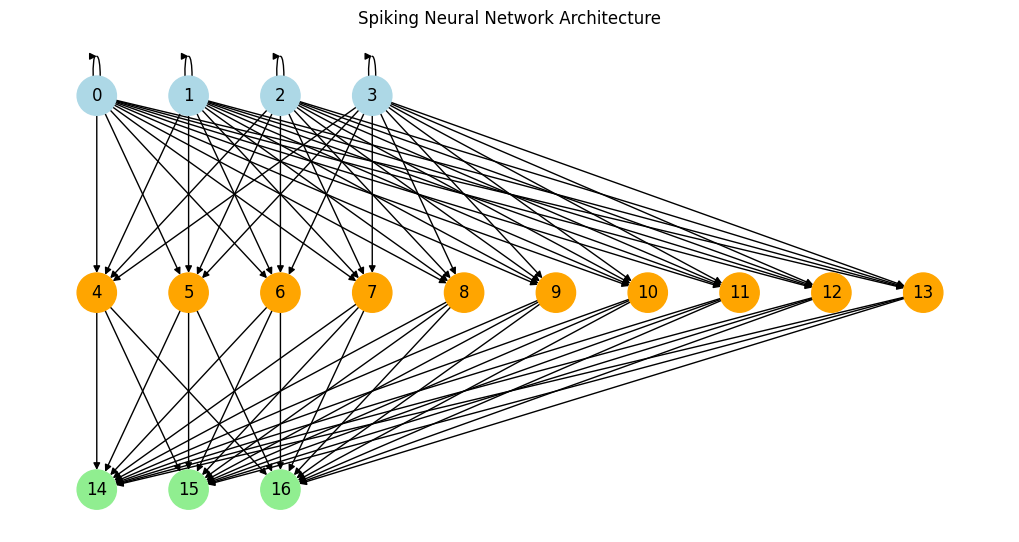

In [91]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Define neuron indices for each layer
input_neurons = range(0, n_input)
hidden_neurons = range(n_input, n_input + n_hidden)
output_neurons = range(n_input + n_hidden, n_total)

# Add nodes with layer info
for i in input_neurons:
    G.add_node(i, layer='input')
for i in hidden_neurons:
    G.add_node(i, layer='hidden')
for i in output_neurons:
    G.add_node(i, layer='output')

# Add edges for each synapse type
G.add_edges_from([(i, j) for i, j in zip(syn_input.i[:], syn_input.j[:])])
G.add_edges_from([(i + 0, j + n_input) for i, j in zip(syn_hidden.i[:], syn_hidden.j[:])])
G.add_edges_from([(i + n_input, j + n_input + n_hidden) for i, j in zip(syn_output.i[:], syn_output.j[:])])

# Define positions for better layer-wise layout
pos = {}
layer_y = {'input': 1, 'hidden': 0.5, 'output': 0}
for i in G.nodes():
    if G.nodes[i]['layer'] == 'input':
        pos[i] = (i, layer_y['input'])
    elif G.nodes[i]['layer'] == 'hidden':
        pos[i] = (i - n_input, layer_y['hidden'])
    else:
        pos[i] = (i - n_input - n_hidden, layer_y['output'])

# Node colors by layer
color_map = []
for node in G:
    layer = G.nodes[node]['layer']
    if layer == 'input':
        color_map.append('lightblue')
    elif layer == 'hidden':
        color_map.append('orange')
    else:
        color_map.append('lightgreen')

# Draw graph
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=True, node_color=color_map, arrows=True, node_size=800)
plt.title("Spiking Neural Network Architecture")
plt.show()

WARNING    'i' is an internal variable of group 'synapses_234', but also exists in the run namespace with the value 3. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 3 lines of abstract code, first line is: 'spikes_received += 1 (in-place)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignor

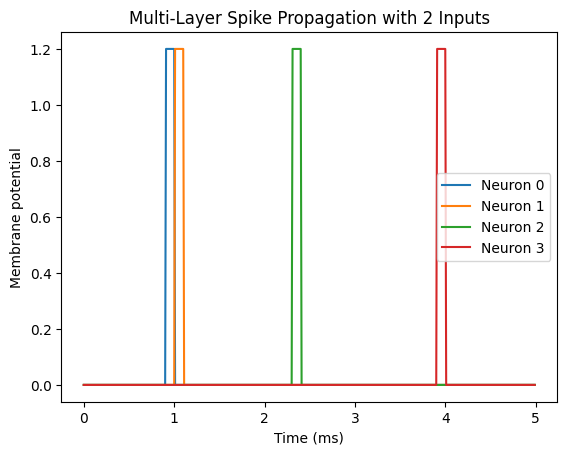

Spike times: {0: array([1.]) * msecond, 1: array([1.1]) * msecond, 2: array([2.4]) * msecond, 3: array([4.]) * msecond}


In [ ]:
# multi with combining inputs to create varing output

from brian2 import *

start_scope()

# Custom timing function
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1, sum=1, spikes_received=1)
def spike_timing(w, global_clock, layer, sum, spikes_received): 
    
    # main block that is calcualing the sigmoid like shift then adding layer
    x = global_clock % 1
    
    if w >= 0:
        #print((x ** (1 - w)))
        return (x ** (1 - w))
    else:
        #print((1 - (1 - x) ** (1 + w)))
        return (1 - (1 - x) ** (1 + w))
        
    return 0
    #print(sum)
    print(spikes_received)
    return layer + (sum) # right now an average but we'll see
    

# 4 Neurons: 0 & 1 = hidden, 2 = integrator, 3 = output
neurons = NeuronGroup(4, '''
    v : 1
    sum : 1
    spikes_received : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.v = 0
neurons.scheduled_time = 1e9 * second
neurons.global_clock = 0.0
neurons.sum = 0.0
neurons.spikes_received = 0

# Two spike inputs
stim = SpikeGeneratorGroup(2, indices=[0, 1], times=[0.1, 0.1]*ms)

# Input layer: stim[0] → neuron[0], stim[1] → neuron[1]
syn_input = Synapses(stim, neurons[0:2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
    
''')
syn_input.connect(j='i')  # connect stim[i] to neurons[i]
syn_input.w = [-0.7, -0.5]
syn_input.layer = [1, 1]

# Hidden layer: neuron[0] & neuron[1] → neuron[2]
syn_hidden = Synapses(neurons[0:2], neurons[2], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms  # need to change for order of op for spikes recived(need to make sure it gets += 1 first before it is used layer)
''')
syn_hidden.connect()
syn_hidden.w = [0.6, 0.8]
syn_hidden.layer = [2, 2]

# Output layer: neuron[2] → neuron[3]
syn_output = Synapses(neurons[2], neurons[3], '''
    w : 1
    layer : 1
''', on_pre='''
    spikes_received += 1
    sum += spike_timing(w, global_clock, layer, spikes_received, sum)
    scheduled_time = ((sum/spikes_received) + layer) * ms 
''')
syn_output.connect()
syn_output.w = 1.0
syn_output.layer = 3

# Scheduled activation & clock update
neurons.run_regularly('''
    v = int(abs(t - scheduled_time) < 0.05*ms) * 1.2

               
    global_clock += 0.01
''', dt=0.01*ms)

# Monitors
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
mon2 = StateMonitor(neurons, 'spikes_received', record=True, dt=0.01*ms)


spikemon = SpikeMonitor(neurons)

# Run simulation
run(5*ms)

# Plot neuron voltages
for i in range(4):
    plot(mon.t/ms, mon.v[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Multi-Layer Spike Propagation with 2 Inputs')
legend()
show()

# Print spikes
print("Spike times:", spikemon.spike_trains())
#print("# of spikes received by neuron 0:", mon2.spikes_received[0])



WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]
[0.01]
+ ===  [2.39810717]


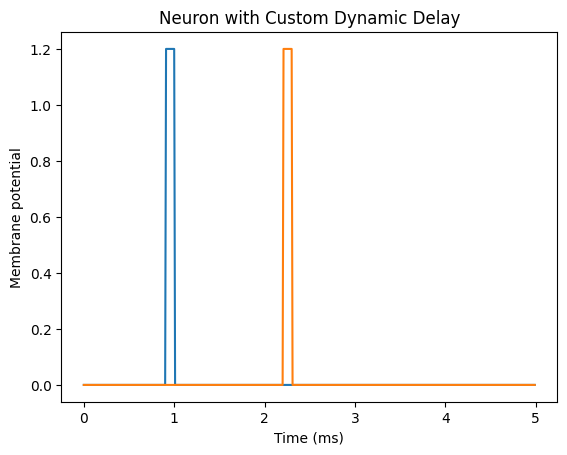

Spike times for neuron 0: {0: array([1.]) * msecond, 1: array([2.3]) * msecond}


In [23]:
# Created another Layer here so Input --> N1 --> N2

from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(2, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




syn0 = Synapses(stim, neurons[0], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn0.connect()
syn0.w = -0.7
syn0.layer = 1

# Hidden → Output synapse
syn1 = Synapses(neurons[0], neurons[1], '''
    w : 1
    layer : 1
''', on_pre='''
    scheduled_time = spike_timing(w, global_clock, layer) * ms
''')
syn1.connect()
syn1.w = 0.8
syn1.layer = 2


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
plot(mon.t/ms, mon.v[1])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains())
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. Abstract code: 'scheduled_time = ms * spike_timing(w, global_clock, layer)'
 [brian2.codegen.generators.base]


[0.11]
- ===  [1.0343561]


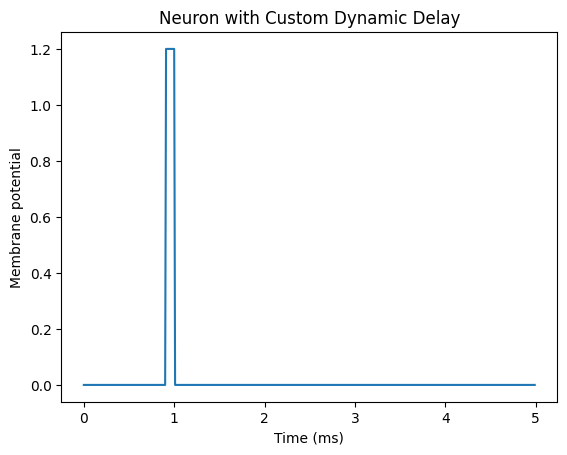

Spike times for neuron 0: [1.] ms


In [14]:
#complete 1 neuron working input to biased output
from brian2 import *

start_scope()

# can remove layer if we know all within 1ms each layer 
@implementation('numpy', discard_units=True)
@check_units(w=1, global_clock=1, layer=1, result=1)
def spike_timing(w, global_clock, layer): 
    x = ((global_clock) % 1) 
    #layer_bias = int((t/ms)/2000)   # why by 200 not even a unit of bias ms --> mew seconds and such
    print(x)
    if not (0 <= x <= 1 and -1 <= w <= 1):
        raise ValueError("x must be in [0, 1] and w in [-1, 1]")
    if w >= 0:
        print("+ === ", layer + (x ** (1 - w)))
        return layer + (x ** (1 - w))
    else:
        print("- === ", layer + (1 - (1 - x) ** (1 + w)))
        return layer + (1 - (1 - x) ** (1 + w))
    



global_time = 0.0 # alreay to t var
input_val   = 0.1


#  ====== neuron gen here =========
neurons = NeuronGroup(1, '''
    v : 1
    scheduled_time : second
    global_clock : 1
''', threshold='v > 1', reset='v = 0', method='exact')
neurons.scheduled_time = 1e9 * second  # init with far-future
neurons.global_clock = 0.0   # will make new method but a pain to work out so useing this for now

# Spike generator
stim = SpikeGeneratorGroup(1, indices=[0], times=[input_val]*ms)




# Synapse
syn = Synapses(stim, neurons,
               '''
               w : 1
               layer : 1
               ''',
               on_pre='''
               scheduled_time = spike_timing(w, global_clock, layer) * ms
               ''')

syn.connect()
syn.w = -0.7
syn.layer = 1


# Apply effect when scheduled time arrives # the werid eq is just for rounding  if error and both 0 will it not fire?
neurons.run_regularly('''    
v = int(int(t / (0.1*ms)) == int(scheduled_time / (0.1*ms))) * 1.2
global_clock += 0.01
''', dt=0.01*ms)


# Monitor
mon = StateMonitor(neurons, 'v', record=True, dt=0.01*ms)
spikemon = SpikeMonitor(neurons)

run(5*ms)

# Plot
plot(mon.t/ms, mon.v[0])
xlabel('Time (ms)')
ylabel('Membrane potential')
title('Neuron with Custom Dynamic Delay')
show()

# Print spike times
print("Spike times for neuron 0:", spikemon.spike_trains()[0])
# Or equivalently:
#print("All spike times:", spikemon.t)
# print("Neuron indices:", spikemon.i)


In [83]:
list = [0,1,2,3]

print(list[0:4])

[0, 1, 2, 3]
